# Kalman Filters

<a href="https://colab.research.google.com/github/warwickdatascience/subject-examples/blob/master/python/physics/physics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

### Problem Statement

Kalman filtering is a technique used to estimate the state of a system over time given noisy measurements of a noisy proces. Under assumptions of linearity and Gaussian noise, it gives optimal estimates for the values of the underlying, unknown system variables. The algorithm is two-fold, first producing estimates of the current state and corresponding uncertainties, before performing a update using the observed value. Kalman filters are used heavily in navigation, control systems, and signal processing. For a simple introduction, we will use a Kalman filter to estimate the position of a ball falling through a viscous fluid over time, given noisy measurements of its height from the base of the container. We will focus only on the implementation of the Kalman filter; for an explanation of the algorithm see [here](https://en.wikipedia.org/wiki/Kalman_filter) or [here](https://www.youtube.com/playlist?list=PLX2gX-ftPVXU3oUFNATxGXY90AULiqnWT).

### Resources

In this example, we use simulated data, though it would easily be possible to link this approach to real data sources.

### Non-course Techniques

We use a package called `matplotlib` to create the final visualisation and `numpy` to help with linear algebra, but all other code is taken from the course.

## Setup

We begin by importing any relevant modules and setting the graphical parameters for `matplotlib`.

In [1]:
import math
import random

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rcParams.update({'font.size': 12})
mpl.rcParams.update({'figure.facecolor': 'white'})

This notebook is parameterised by the variables defined below. Note, measurements will take place until the ball reaches the bottom of the container.

In [3]:
g = 9.8  # acceleration due to gravity
k = 0.5  # coefficient of (viscous) resistance
m = 1  # mass of ball
x_0 = 100  # initial height
dt = 0.1  # measurement interval
# NB: we assume measurement and process errors are uncorrelated
Q = np.diag([1, 0.1])  # process noise
R = np.diag([20, 5])  # measurement noise

SEED = 1729  # random seed for reproducibility

We start by simulating the trajectory of the ball and noisy measurements of height.

In [4]:
random.seed(SEED)
x, v, t = [x_0], [0], [0]  # stationary start
# Measurements
xm = [x_0 + random.gauss(0, math.sqrt(R[0,0]))]
vm = [0 + random.gauss(0, math.sqrt(R[1,1]))]

while True:
    x_new = x[-1] - v[-1] * dt + random.gauss(0, math.sqrt(Q[0,0]))
    xm_new = x_new + random.gauss(0, math.sqrt(R[0,0]))
    v_new = v[-1] + (g - k/m * v[-1]) * dt + random.gauss(0, math.sqrt(Q[1,1]))
    vm_new = v_new + random.gauss(0, math.sqrt(R[1,1]))
    t_new = t[-1] + dt
    # Check if hit ground
    if x_new <= 0:
        break
    # Append results
    x.append(x_new); xm.append(xm_new)
    v.append(v_new); vm.append(vm_new)
    t.append(t_new)

## Filtering

We can now use our noisy measurments to estimate the underlying state space via the Kalman filter algorithm.

In [5]:
xp, vp = [xm[0]], [vm[0]]  # predictions
P = R[:,:]  # prediction error estimate
A = np.array([
    [1, -dt],
    [0, 1 - k/m * dt]
])  # transition matrix
for i in range(1, len(t)):
    # Predict new state and error
    xp_new = xp[-1] - vp[-1] * dt
    vp_new = vp[-1] + (g - k/m * vp[-1]) * dt 
    P = np.matmul(np.matmul(A, P), A.T) + Q
    # Calculate Kalman gain
    K = np.matmul(P, np.linalg.inv(P + R))
    # Corrections based on observation
    xp_new += K[0,0] * (xm[i] - xp_new) + K[0,1] * (vm[i] - vp_new)
    vp_new += K[1,1] * (vm[i] - vp_new) + K[1,0] * (xm[i] - xp_new)
    P = np.matmul(np.identity(2) - K, P)
    # Append results
    xp.append(xp_new)
    vp.append(vp_new)

## Visualisation

Lastly, we visualise the results. The blue line shows the true state of the system, the red dots show noisy measurements, and the green line shows the predicted state (which is far less noisy than the provided measurements).

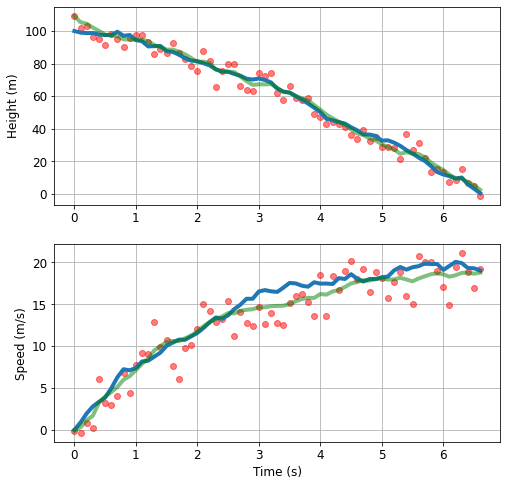

In [6]:
fig, axs = plt.subplots(2, figsize=(8, 8))
axs[0].plot(t, x, linewidth=4)
axs[0].scatter(t, xm, c='r', alpha=0.5)
axs[0].plot(t, xp, c='g', alpha=0.5, linewidth=4)
axs[1].plot(t, v, linewidth=4)
axs[1].scatter(t, vm, c='r', alpha=0.5)
axs[1].plot(t, vp, c='g', alpha=0.5, linewidth=4)
axs[1].set_xlabel('Time (s)')
axs[0].set_ylabel('Height (m)')
axs[1].set_ylabel('Speed (m/s)')
for ax in axs:
    ax.grid()
    ax.set_axisbelow(True)